第5回　CNNによる画像分類

今回は，より精度の高い画像分類が可能なCNNについて学んでいきます．

１，CNNとは

CNN（畳み込みニューラルネットワーク）とは，「畳み込み層」・「プーリング層」と線形層により構成されるモデルのひとつで，線形層のみで構成されるモデルよりも少ないデータ数で精度の高い推論が可能となります．以下のリンクにCNNの概要を示します．

<img src="https://www.analog.com/-/media/images/analog-dialogue/en/volume-57/number-1/articles/max78000-article-series-part-1/480370-fig-03.svg?w=435">

畳み込み層とは，カーネルと呼ばれる小さな行列を用いることで，畳み込み処理を行う層です．下のリンクに畳み込み処理を行う様子がGIFにより分かりやすく示されているので，確認してみてください．

<img src="https://camo.qiitausercontent.com/12545193254e3938b8914f22cdff6e238eab2d4b/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3232313834352f33636231326232312d383539612d393331312d326165362d3735363932383231313931302e676966">

pytorchでは，畳み込み層をnn.Conv2dと定義しており，そのコンストラクタは主に4つの引数を取ります．入力チャネル数，出力チャネル数，カーネルサイズ，ストライドサイズです．

In [1]:
from torch import nn

input_channel=3 #畳み込み層の入力チャネル数
output_channel=6 #畳み込み層の出力チャネル数（カーネルの数でもある）
kernel_size=5 #カーネルのサイズ（5×5）
stride_size=2 #ストライドサイズ

conv=nn.Conv2d(input_channel,output_channel,kernel_size,stride_size)

print(conv)

Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2))


ストライドサイズとは，畳み込みの動作において，カーネルをずらすピクセル数のことを指します．上のリンクだと，カーネルが1マスずつずれているので，ストライドサイズは1となります．以下のリンクに，ストライドサイズを2とした時の，畳み込みの様子を示します．

<img src="https://deepage.net/img/convolutional_neural_network/stride2.gif">

畳み込み層では，このカーネルのサイズやストライドサイズを大きくすると，出力の二次元データのサイズは小さくなります．以下のコードでは，(28,28)の二次元データをそれぞれ，カーネルサイズ・ストライドサイズが異なる畳み込み層に入力し，得られたデータのサイズを表示しています．

In [3]:
import torch

input=torch.rand(3,28,28) #ランダムなチャネル数3，サイズ(28,28)の二次元データ

conv1=nn.Conv2d(3,6,4,1) #入力チャネル3，出力6，カーネルサイズ4，ストライドサイズ1
conv2=nn.Conv2d(3,6,7,4) #カーネルサイズ7，ストライドサイズ4

output1=conv1(input)
print(output1.size()) #チャネル数6の(25,25)のデータ
output2=conv2(input)
print(output2.size()) #チャネル数6の(6,6)のデータ

torch.Size([6, 25, 25])
torch.Size([6, 6, 6])


このように，カーネル・ストライドサイズが大きくなると，畳み込み層の出力サイズは小さくなることが確認できます．また，畳み込み層の出力で得られたデータは，「特徴量マップ」と呼ばれます．

出力のサイズが小さくなってしまうと，データが順伝搬を行う際に，情報量がだんだんと減少してしまい，学習がしずらくなります．その分をチャネル数で補うという方法もありますが，こうしたデータサイズの縮小を抑えるために，「ゼロパディング」を行うことがあります．

ゼロパディングとは，畳み込み層などの出力のサイズ低下の影響を少なくするため，入力データの周りに，値0のデータを配置して，データの補完を行うというものです．以下のリンクに，ゼロパディングの概要を，その下のコードに，nn.Conv2dでパディングを行うコードを示します．

<img src="https://resources.zero2one.jp/2022/05/ai_exp_206-2-1024x576.jpeg">

In [4]:
import torch

padding_size=2 #パディングサイズ

input=torch.rand(3,28,28) #ランダムなチャネル数3，サイズ(28,28)の二次元データ

conv3=nn.Conv2d(3,6,7,4) #入力チャネル3，出力6，カーネルサイズ7，ストライドサイズ4
conv4=nn.Conv2d(3,6,7,4,padding_size) #カーネルサイズ7，ストライドサイズ2 パディング数2

output1=conv3(input)
print(output1.size()) #チャネル数6の(6,6)のデータ
output2=conv4(input)
print(output2.size()) #チャネル数6の(7,7)のデータ

torch.Size([6, 6, 6])
torch.Size([6, 7, 7])


プーリング層とは，入力データをより扱いやすい形に変換するため，情報を圧縮するための処理（プーリング）を行う層です．プーリングにはいくつか種類がありますが，代表的なものとしてマックスプーリングと呼ばれる手法が挙げられます．以下のリンクにマックスプーリングの様子を示します．

<img src="https://deepage.net/img/convolutional_neural_network/max_pooling.jpg">

マックスプーリングは，ある入力データの一部から最大値を選び，その値を，一つのマスの要素にするというものです．pytorchでは，マックスプーリングを行うプーリング層はnn.MaxPool2dで定義されています．以下のコードは，任意の大きさの二次元データに対してマックスプーリングを行った結果を出力します．

In [5]:
input=torch.rand(3,4,4) #チャネル数3，(4,4)のランダムな値を生成
pool1=nn.MaxPool2d(2,2) #(2,2)のデータを選ぶ，ストライドサイズ2
output=pool1(input)
print("プーリング前\n",input) #元の入力データ
print("\nプーリング後\n",output) #プーリング後のデータ

プーリング前
 tensor([[[0.8318, 0.8794, 0.6467, 0.0164],
         [0.4557, 0.9951, 0.1748, 0.0589],
         [0.1580, 0.3041, 0.1387, 0.5801],
         [0.6775, 0.7894, 0.3138, 0.8816]],

        [[0.6971, 0.6244, 0.0279, 0.1668],
         [0.5808, 0.6770, 0.8730, 0.3953],
         [0.1056, 0.5978, 0.5298, 0.0647],
         [0.8901, 0.5938, 0.7135, 0.1471]],

        [[0.5173, 0.8276, 0.9222, 0.0678],
         [0.2762, 0.3131, 0.5413, 0.6138],
         [0.7360, 0.6918, 0.2084, 0.6430],
         [0.1111, 0.0133, 0.0694, 0.1183]]])

プーリング後
 tensor([[[0.9951, 0.6467],
         [0.7894, 0.8816]],

        [[0.6971, 0.8730],
         [0.8901, 0.7135]],

        [[0.8276, 0.9222],
         [0.7360, 0.6430]]])


今回の場合だと，プーリングした際に出てくるデータは，四つ角の(2,2)の領域の中の最大値となっています．

畳み込みとプーリングが完了したデータは，チャネル数1の一次元テンソルにしてあげないといけません．これは，線形層の入力が一次元しか受け付けないためです．以下のコードは，畳み込みが完了したデータを，チャネル数1の一次元テンソルに変換する処理を示しています．

In [6]:
input=torch.rand(3,32,32) #チャネル数3，(4,4)のランダムな値を生成
conv5=nn.Conv2d(3,6,5) #入力チャネル3，出力6，カーネルサイズ5
pool1=nn.MaxPool2d(2,2) #(2,2)のデータを選ぶ，ストライドサイズ2
output=pool1(conv5(input))
print("\n畳み込み&プーリング後\n",output.size()) #プーリング後のデータ
#viewメソッドを使えば，一次元のテンソルに直せる
flatten_out=output.view(-1,output.size()[0]*output.size()[1]*output.size()[2])
print("\nフラット後\n",flatten_out.size())


畳み込み&プーリング後
 torch.Size([6, 14, 14])

フラット後
 torch.Size([1, 1176])


しかし，viewメソッドはコードが冗長化する原因となるので，かわりに,torch.flatten()というメソッドを使いましょう．

In [7]:
input=torch.rand(3,32,32) #チャネル数3，(4,4)のランダムな値を生成
conv5=nn.Conv2d(3,6,5) #入力チャネル3，出力6，カーネルサイズ5
pool1=nn.MaxPool2d(2,2) #(2,2)のデータを選ぶ，ストライドサイズ2
output=pool1(conv5(input))
print("\n畳み込み&プーリング後\n",output.size()) #プーリング後のデータ
#torch.flattenを使えば，一次元のテンソルに直せる
flatten_out=torch.flatten(output)
print("\nフラット後\n",flatten_out.size())


畳み込み&プーリング後
 torch.Size([6, 14, 14])

フラット後
 torch.Size([1176])


CNNでは，この畳み込みとプーリングを行うことで，精度の高い推論を実現でき，具体的には，以下のことができるようになります．

・データ量の削減と計算コスト低下

・分類対象の物体の移動に強くなる

２，CNNの実装

CNNが応用される分野は多く，画像分類や音声認識，さらには強化学習やテキスト分類にも使用されています．今回は主に画像分類を通してCNNの実装を行いましょう．

まずはimportからです．

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

次に，データセットを用意します

In [9]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #データの正規化と呼ばれる処理
    ])

batch_size = 4

#訓練用データセットとデータローダー
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

#検証用データセットとデータローダー
testset = datasets.CIFAR10(root='./data', train=False,
                            download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

#分類するクラス（画像の種類）
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


今回使用するデータセットはCIFAR10と呼ばれるもので，10種類のクラスの分類を行います．以下のコードは，CIFAR10の中身を表示するコードです．

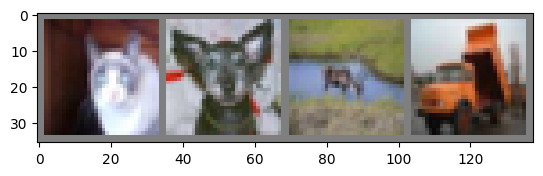

cat   label is 3 dog   label is 5 deer  label is 4 truck label is 9


In [10]:
def imshow(img):
    img = img / 2 + 0.5 #正規化を解除
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() #画像の表示


# データをランダムに抽出
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 画像を表示
imshow(torchvision.utils.make_grid(images))
# ラベル（クラス）を表示
print(' '.join(f'{classes[labels[j]]:5s} label is {labels[j]}' for j in range(batch_size)))

次はCNNモデルの定義に入ります．

In [11]:
class Net(nn.Module): #モデルの定義
    def __init__(self): #コンストラクター
        super().__init__() #nn.Moduleの初期化実行
        self.conv=nn.Sequential(
            nn.Conv2d(3,6,5), #rgbのデータなので，入力チャネル数は3
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.linear=nn.Sequential(
            nn.Linear(16*5*5,120), #注目
            nn.ReLU(),
            nn.Linear(120,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
        )
    
    def forward(self,x):
        x=self.conv(x)
        x=torch.flatten(x,1) #チャネル数含む全次元が平坦化して，線形層に入力できる
        x=self.linear(x)
        return x

net=Net()

ここで，注意する点は，畳み込みと，プーリングを行うことによる画像データのサイズ変化です．一つ目の線形層の入力は16×5×5となっていますが，これは，実験的に求めた値となります．一応理論式は存在しますが，面倒くさいので実験的に求めることが多いです．

In [12]:
conv6=nn.Sequential(
    nn.Conv2d(3,6,5), #rgbのデータなので，入力チャネル数は3
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
)
x=torch.rand(3,32,32) #CIFARの画像データと同じサイズ条件
print(conv6(x).size())

torch.Size([16, 5, 5])


これをしないと入力エラーが発生するので，必ずサイズチェックだけは行って下さい．

次は，損失関数とオプティマイザの定義です．今回はtorch.nn.MultiMarginLoss()を損失関数に，Adam()をオプティマイザとして利用してみます．Adamはかなり優秀なオプティマイザです．

In [13]:
loss_fn=nn.MultiMarginLoss()
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)

In [14]:
for epoch in range(4): #学習ループ

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #データとラベルを取出し
        inputs, labels = data

        #傾きをゼロにリセット
        optimizer.zero_grad()

        #順伝搬，誤差逆伝搬
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # 学習の進捗確認
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Done')

[1,  2000] loss: 0.538
[1,  4000] loss: 0.391
[1,  6000] loss: 0.360
[1,  8000] loss: 0.337
[1, 10000] loss: 0.331
[1, 12000] loss: 0.315
[2,  2000] loss: 0.289
[2,  4000] loss: 0.290
[2,  6000] loss: 0.284
[2,  8000] loss: 0.278
[2, 10000] loss: 0.279
[2, 12000] loss: 0.280
[3,  2000] loss: 0.254
[3,  4000] loss: 0.257
[3,  6000] loss: 0.258
[3,  8000] loss: 0.254
[3, 10000] loss: 0.261
[3, 12000] loss: 0.250
[4,  2000] loss: 0.238
[4,  4000] loss: 0.237
[4,  6000] loss: 0.239
[4,  8000] loss: 0.244
[4, 10000] loss: 0.241
[4, 12000] loss: 0.234
Done


最後に，学習させたCNNモデルのテストをします．

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'画像10000枚でのモデルの平均精度: {100 * correct // total} %')

画像10000枚でのモデルの平均精度: 56 %


今回は学習回数がたった4回だったので少し微妙ですね．学習回数を上げるとさらに精度が高くなりますが，学習にはかなりの時間を要します．そこで，次回はさらに精度の高い推論をできるように，転移学習というものを行ってみましょう．